In [1]:
%run imports.ipynb

In [8]:
li2016_calls = pd.read_excel('source_data/variant_calls.xlsx', sheet_name='Li2016')
li2016_calls.rename({'Name': 'name'}, axis=1).to_csv('source_data/li2016_variant_calls.csv', index=False)

li2016_calls = pd.read_csv('source_data/li2016_variant_calls.csv')
sample2status = {r.name:r.status for r in li2016_calls.to_records()}
run2status = {r.run_rrbs:r.status for r in li2016_calls.to_records()} # SRR* -> R882/Other/WT/INS

### Bivalent domain 정의는 어떻게?

10_TssBiv, 11_BivFlnk, 12_EnhBiv state들을 모아서 bivalent domain으로 정의함.

In [11]:
intersect_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/DBGAP-DMR-PILEUP/result/intersect/*.bivalent_domains_center.bed')
closest_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/DBGAP-DMR-PILEUP/result/closest/*.bivalent_domains_center.bed')

len(intersect_results), len(closest_results)

intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

intersect_data = []

for fp in tqdm(intersect_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=intersect_names)
    tmp['sample'] = sample
    
    intersect_data.append(tmp)
    
intersect_data = pd.concat(intersect_data)

intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

closest_data = []

for fp in tqdm(closest_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=closest_names)
    tmp['sample'] = sample
    
    closest_data.append(tmp)
    
closest_data = pd.concat(closest_data)

intersect_data['distance_bin'] = pd.cut(intersect_data.rel_pos, bins=np.linspace(0, 1, 51))

intersect_data.head(3)

intersect_data['status'] = intersect_data['sample'].map(run2status).fillna('NBM')
closest_data['status'] = closest_data['sample'].map(run2status).fillna('NBM')

closest_data_upstream = closest_data[closest_data.distance < 0].copy()
closest_data_downstream = closest_data[closest_data.distance > 0].copy()

closest_data_upstream['distance_bin'] = pd.cut(closest_data_upstream.distance, bins=np.linspace(-3000, 0, 101))
closest_data_downstream['distance_bin'] = pd.cut(closest_data_downstream.distance, bins=np.linspace(0, 3000, 101))

intersect_data_grouped = intersect_data.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()

%time closest_data_upstream_grouped = closest_data_upstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()
%time closest_data_downstream_grouped = closest_data_downstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()

100%|██████████| 108/108 [01:17<00:00,  1.39it/s]


CPU times: user 3.87 s, sys: 249 ms, total: 4.11 s
Wall time: 4.11 s
CPU times: user 3.56 s, sys: 185 ms, total: 3.74 s
Wall time: 3.74 s


In [16]:
pileup_data = pd.concat([closest_data_upstream_grouped, closest_data_downstream_grouped])
pileup_data.to_csv('source_data/biv_domain_beta_landscape.csv', index=False)

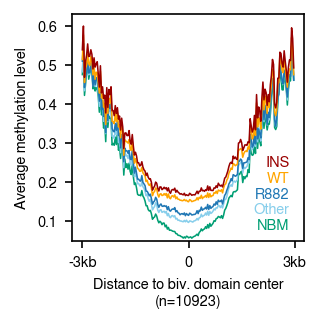

In [17]:
pileup_data = pd.read_csv('source_data/biv_domain_beta_landscape.csv')

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)

for i, (c, status) in enumerate(zip(['#009e73', 'skyblue', 'C0', 'orange', '#990000'], ['NBM', 'Other', 'R882', 'WT', 'INS'])):
    ax.plot(pileup_data[pileup_data.status == status].beta.values, lw=0.75, c=c)
    ax.text(195, 0.08 + 0.04 * i, status, ha='right', color=c)

ax.set_xticks([0, 100, 200])
ax.set_xticklabels(['-3kb', '0', '3kb'], fontsize=7)
ax.set_ylabel('Average methylation level')
ax.set_xlabel('Distance to biv. domain center\n(n=10923)', fontsize=7)

ax.set_ylim([0.05, 0.63])

save_figures('source_data_figures/bivalent_domain_beta_landscape/bivalent_domain_beta_landscape')